In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from poliastro.twobody import State
from poliastro.bodies import Earth
Earth.k = 398600.4329 * u.km**3 / u.s**2  # GTOC 8

In [3]:
import sys
sys.path.insert(0, "..")
from gtoc8 import lib, io
from gtoc8.integrate import *

In [4]:
import importlib

In [5]:
catalogue = io.load_catalogue("../data/gtoc8_radiosources.txt")
catalogue.head()

,RA (deg),DEC (deg)
1,359.92065,-88.78955
2,356.91670,-80.27817
3,64.09616,-79.25290
4,118.90179,-80.08681
5,181.02500,-82.32760


# Estado inicial

Los tres son iguales

In [5]:
ss_A0 = State.circular(Earth, 400 * u.km)
ss_B0 = State.circular(Earth, 400 * u.km)
ss_C0 = State.circular(Earth, 400 * u.km)

In [6]:
initial_period = ss_A0.period
initial_period.to(u.h)

<Quantity 1.5426730845104508 h>

Creamos el vector de tiempos: de 0 a 280 días (diez períodos lunares)

In [7]:
t = np.linspace(0 * u.h, 280 * u.day, 500000)
print (t[1] - t[0]).to(u.minute)

0.806401612803 min


Probamos a dar una maniobra a los tres satélites desfasada $T / 3$.

In [8]:
from poliastro.maneuver import Maneuver
from poliastro.util import norm

In [9]:
max_dv = 3 * u.km / u.s

In [10]:
# Maniobra en el plano
vec_A = ss_A0.v
man_A = Maneuver.impulse(vec_A / norm(vec_A) * max_dv)
man_A.impulses[0]

(<Quantity 0.0 s>, <Quantity [ 0., 3., 0.] km / s>)

In [11]:
man_A.get_total_cost()

<Quantity 3.0 km / s>

In [12]:
# Maniobra con componente vertical hacia arriba
vec_B = ss_B0.propagate(initial_period / 3).v + [0, 0, 3] * u.km / u.s
man_B = Maneuver((initial_period / 3, vec_B / norm(vec_B) * max_dv))
tuple(_.decompose([u.km, u.s]) for _ in man_B[0])

(<Quantity 1851.207701412541 s>,
 <Quantity [-2.41951897,-1.39690993, 1.09296413] km / s>)

In [13]:
man_B.get_total_cost()

<Quantity 3.0 km / s>

In [14]:
# Maniobra con componente vertical hacia abajo
vec_C = ss_C0.propagate(2 * initial_period / 3).v + [0, 0, -3] * u.km / u.s
man_C = Maneuver((2 * initial_period / 3, vec_C / norm(vec_C) * max_dv))
tuple(_.decompose([u.km, u.s]) for _ in man_C[0])

(<Quantity 3702.415402825082 s>,
 <Quantity [ 2.41951897,-1.39690993,-1.09296413] km / s>)

In [15]:
man_C.get_total_cost()

<Quantity 3.0 km / s>

In [16]:
ss_A = ss_A0.apply_maneuver(man_A).propagate(initial_period)
ss_B = ss_B0.apply_maneuver(man_B).propagate(2 * initial_period / 3)
ss_C = ss_C0.apply_maneuver(man_C).propagate(initial_period / 3)

In [6]:
from poliastro.plotting import OrbitPlotter

In [7]:
SIMULATION_NUMBER = 2
conf = importlib.import_module("gtoc8.simulations.conf%d.conf" % SIMULATION_NUMBER)

In [8]:
ss_A, ss_B, ss_C, t = conf.config()

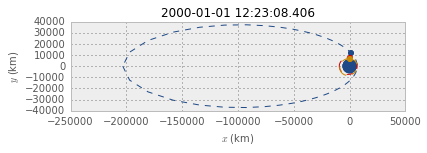

In [9]:
with plt.style.context("pybonacci"):
    op = OrbitPlotter()
    op.plot(ss_A)
    op.plot(ss_B)
    op.plot(ss_C)

In [10]:
ss_A.epoch.mjd

51544.51606951129

In [11]:
ss_B.epoch.mjd

51544.51606951129

In [12]:
ss_C.epoch.mjd

51544.51606951129

In [13]:
ss_A.inc

<Quantity 0.0 deg>

In [16]:
ss_B.r

<Quantity [  336.31352683, 7223.63348025, 2825.94179876] km>

In [17]:
ss_C.r

<Quantity [   33.25836368, 6860.97714114,-2163.80883736] km>

<div class="alert alert-info">**Nota**: Esto es una proyección (ya hemos visto que las maniobras tenían una componente fuera del plano). Para visualizar esto en tres dimensiones, vamos a utilizar las funciones creadas a tal efecto.</div>

In [144]:
from gtoc8.visual import plot_gtoc8

In [145]:
def state_to_vector(ss):
    x0, y0, z0 = ss.r.to(u.km).value
    vx0, vy0, vz0 = ss.v.to(u.km / u.s).value
    return np.array([x0, y0, z0, vx0, vy0, vz0])

In [146]:
s1 = state_to_vector(ss_A)[:3]
s2 = state_to_vector(ss_B)[:3]
s3 = state_to_vector(ss_C)[:3]

<IPython.core.display.Javascript object>


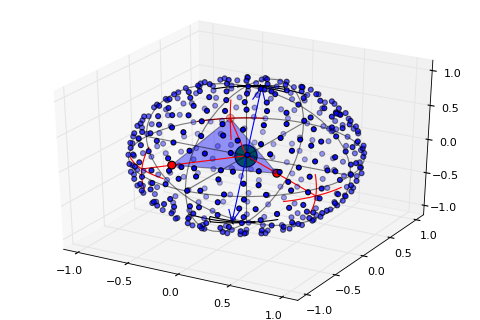

In [147]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

plot_gtoc8(s1, s2, s3, ax, catalogue)

Ahora vamos a propagar la órbita de los satélites en el tiempo dado:

In [161]:
u1 = state_to_vector(ss_A)
u2 = state_to_vector(ss_B)
u3 = state_to_vector(ss_C)

In [185]:
sol1 = integrate_rk4_numba(t, u1)
sol2 = integrate_rk4_numba(t, u2)
sol3 = integrate_rk4_numba(t, u3)

Representamos la distancia angular de **una** radiofuente concreta al vector de observación en función del tiempo

In [186]:
%timeit lib.observation_triangle(s1, s2, s3)

The slowest run took 4.79 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 134 µs per loop


In [195]:
catalogue.iloc[412]

RA (deg)      5.49574
DEC (deg)    80.50522
Name: 413.0, dtype: float64

In [ ]:
dist_one = np.zeros((len(t), len(catalogue)))
for ii in range(len(t)):
    s1 = sol1[ii, :3]
    s2 = sol2[ii, :3]
    s3 = sol3[ii, :3]
    vec, _ = lib.observation_triangle(s1, s2, s3)
    for jj in range(len(catalogue)):
        ra, dec = np.deg2rad(catalogue.iloc[jj].values)
        dist_one[ii, jj] = lib.distance_radio_source(vec, ra, dec)

In [ ]:
for jj in range(len(catalogue)):
    plt.plot(t.value, dist_one[:, jj])

In [ ]:
dist_one.max()

In [ ]:
dist_one.min()

In [ ]:
(np.arccos(dist_one.max()) * u.rad).to(u.deg)

Conclusiones:

* Las distancias angulares evolucionan poquísimo en períodos muy largos incluso con diferencias de inclinación apreciables entre las órbitas
* La integración y evaluación de las distancias angulares, incluso sin empuje alguno, lleva tiempos del orden de 15 minutos